In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pandas as pd
import pyplot_themes as themes
import matplotlib.ticker as mtick

import sys 

# Turn off value-on-slice warning
pd.options.mode.chained_assignment = None  # default='warn'

def make_aesthetic():
    sns.set(rc={'axes.spines.top': False, 'axes.spines.right': False}, style='white', context='poster')
    themes.theme_few('dark')
    plt.rcParams.update({'font.family':'Arial'})

In [2]:
output_path = "../../results/graphs/expr_"

def clean_answer(x):
    if x.startswith("Web search"):
        return "Web Search"
    else:
        return "Social Media"
    
def clean_condition(x):
    if x.startswith("rumor"):
        return "Rumor"
    else:
        return "Announcement"

    
dfs = []
fn = "prompt2_expr.csv"
df = pd.read_csv(fn)
df.columns = df.iloc[0]
df.drop(index=0, inplace=True)
df.drop(index=1, inplace=True)
melted_df = pd.melt(df, id_vars=['What is your prolific ID?', 'Duration (in seconds)', "Please select 'agree' to show you are paying attention",'We care about the quality of our survey data. For us to get the most accurate measures of your opinions, it is important that you provide thoughtful answers to each question in this survey.\nDo you commit to providing thoughtful answers to the questions in this survey?'], 
                    value_vars=df.filter(regex='rumor_\d+_[a-z]+').columns, 
                    var_name='rumor', value_name='answer')
melted_df[['rumor_no', 'rumor_or_announcement']] = melted_df['rumor'].apply(lambda x: pd.Series(x.split('_', maxsplit=2)[1:]))
melted_df.drop(columns=['rumor'], inplace=True)
melted_df = melted_df.dropna()
melted_df.columns = ['pid', 'duration', 'attn_check','commitment','source', 'rumor_no','condition']
melted_df['source'] = melted_df['source'].apply(lambda x: clean_answer(x))
melted_df['condition'] = melted_df['condition'].apply(lambda x: clean_condition(x))
melted_df = melted_df[melted_df['pid'] != '1'] # Test case that I did
df = melted_df.copy()

# df['source'] = pd.Categorical(df['source'], categories=['web_search', 'social_media'])
# df['condition'] = pd.Categorical(df['condition'], categories=['announcement', 'rumor'])



# Did anyone fail commitment or attention checks?

In [3]:
print("Should all be agree:", df['attn_check'].value_counts())
print()
print("Should all say Yes I will", df['commitment'].value_counts())


Should all be agree: Agree    190
Name: attn_check, dtype: int64

Should all say Yes I will Yes, I will    190
Name: commitment, dtype: int64


# Basic Desc Stats

In [4]:
crosstab = np.round(pd.crosstab(df['condition'], df['source'], normalize='index') * 100, 0)
print(crosstab)

source        Social Media  Web Search
condition                             
Announcement          20.0        80.0
Rumor                 41.0        59.0


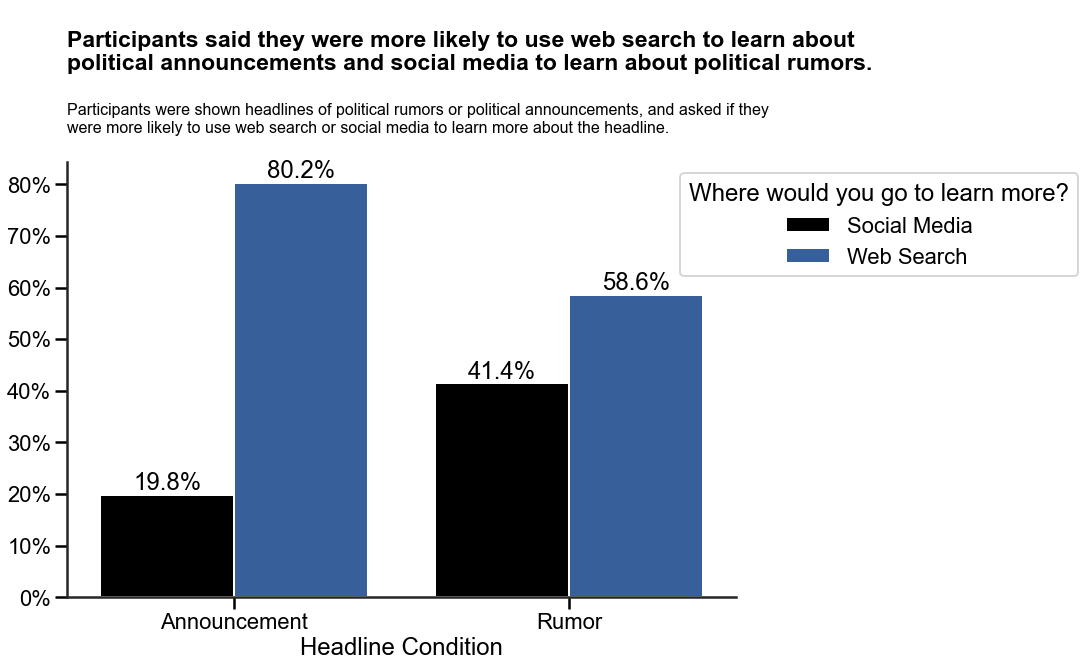

In [5]:
crosstab = np.round(pd.crosstab(df['condition'], df['source'], normalize='index') * 100, 0)
percent_df = df.groupby(['source', 'condition']).size().reset_index(name='counts')
percent_df['condition_sum'] = percent_df.groupby('condition')['counts'].transform('sum')
percent_df['percent'] = percent_df['counts'] / percent_df['condition_sum']


make_aesthetic()
ax = sns.barplot(x='condition', y='percent', hue='source', data=percent_df)
sns.despine()

# Add the percent on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                size=24, xytext=(0, 5),
                textcoords='offset points')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(100*x)}%'))
# Change x-axis tick labels to title case
# Change x-axis tick labels to title case
plt.suptitle(
    "\nParticipants said they were more likely to use web search to learn about\npolitical announcements and social media to learn about political rumors.",
    fontsize=23,
    fontweight="bold",
    x=0.125,
    y=1.15,
    ha="left",
)

plt.title(
    "Participants were shown headlines of political rumors or political announcements, and asked if they\nwere more likely to use web search or social media to learn more about the headline.",
    fontsize=16,
    pad=30,
    loc="left",
)

plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1), title='Where would you go to learn more?',)
plt.ylabel("")
plt.xlabel("Headline Condition")
plt.savefig(f"{output_path}results.png", bbox_inches='tight', dpi=300)

In [10]:
crosstab = np.round(pd.crosstab(df['condition'], df['source'], normalize='index') * 100, 0)
percent_df = df.groupby(['source', 'condition']).size().reset_index(name='counts')
percent_df['source_sum'] = percent_df.groupby('source')['counts'].transform('sum')
percent_df['percent'] = percent_df['counts'] / percent_df['source_sum']

sns.barplot(data=percent_df, x='source', y='perc')

TypeError: Neither the `x` nor `y` variable appears to be numeric.

# Chi2

In [295]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create the contingency table
contingency_table = pd.crosstab(df['condition'], df['source'])

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi2:", chi2)
print("P-value:", p_value)



Chi2: 9.379359158114493
P-value: 0.0021944225217580887


# Logits

In [297]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create a binary variable for source
df['source_binary'] = df['source'].apply(lambda x: 1 if x =='Web Search' else 0)

# Convert pid to categorical
df['pid_cat'] = pd.Categorical(df['pid'])
groups = df['pid']

logit = smf.logit(formula='source_binary ~ C(condition, Treatment("Rumor")) + C(rumor_no)', data=df).fit()
mixed_logit = smf.mixedlm(formula='source_binary ~ C(condition, Treatment("Rumor")) + C(rumor_no)', data=df, groups=groups).fit()

print("LOGIT")
print(logit.summary())
print("\n"*5)
print("MIXED LOGIT")
print(mixed_logit.summary())


Optimization terminated successfully.
         Current function value: 0.558723
         Iterations 6
LOGIT
                           Logit Regression Results                           
Dep. Variable:          source_binary   No. Observations:                  190
Model:                          Logit   Df Residuals:                      179
Method:                           MLE   Df Model:                           10
Date:                Sat, 25 Mar 2023   Pseudo R-squ.:                 0.09814
Time:                        11:40:42   Log-Likelihood:                -106.16
converged:                       True   LL-Null:                       -117.71
Covariance Type:            nonrobust   LLR p-value:                   0.01037
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                 

In [325]:
np.exp(0.1), np.exp(0.3), np.exp(1.07)


(1.1051709180756477, 1.3498588075760032, 2.915379499976997)